In [2]:
from jqdatasdk import *
import jqdatasdk
jqdatasdk.auth('15986661023', '661023')

import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO
from dateutil.parser import parse
import seaborn as sns
import matplotlib as mpl
import os
import statsmodels.api as sm
import scipy
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")
#change the style of plotting
mpl.rcParams['font.family']='serif'
mpl.rcParams['axes.unicode_minus']=False 

auth success 


In [3]:
#define the class that tests the result of efficiency of the strategy
class strategy_backtest(object):
    def init(self,data):
        self.data = data
        self.returndata= data[-1]-1
        self.annualized_return = (data[-1])**(12./len(self.returndata))-1
        self.annualized_volatility = data.pct_change().std()*(12.**0.5)
        
    def maxback(self):
        if argmax(self.data) < argmin(self.data):
            maxback = max(self.data) - min(self.data)
        else:
            maxvalue = 0
            maxback_list = []
            for data_1 in self.data:
                maxvalue = max(maxvalue, data_1)
                maxback_list = maxback_list+[maxvalue-data_1]
            maxback = max(maxback)
        return(maxback)
            
    def sharpe(self):
        bench_mark = 0.03
        sharpe_ratio = (self.annualized_return-bench_mark)/self.annualized_volatility
        return(sharpe_ratio)            

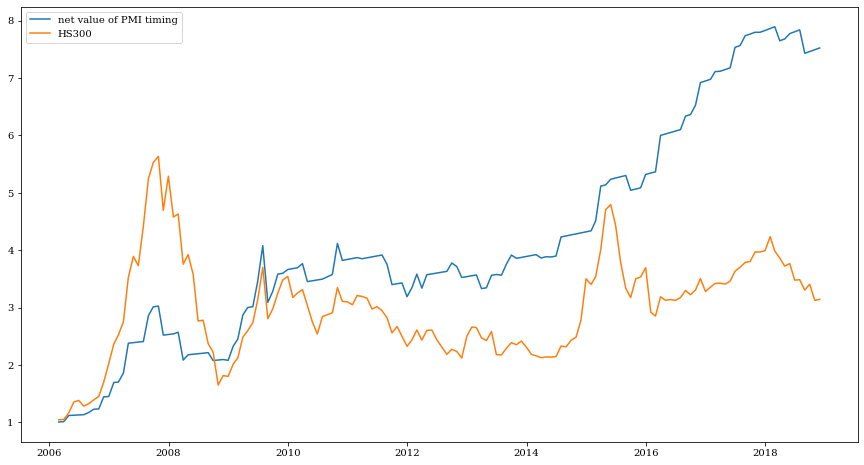

In [85]:
rf = 0.05/12
df_boom=pd.read_excel('PMI组合.xls')
df_boom.index = df_boom['日期']
df_boom = df_boom.loc['2006-01-31':]
df_boom['position'] = (df_boom['PMI'].pct_change()>0)*1
stock_price = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = stock_price.resample('M',how='last')
prices_growth = prices_M.pct_change()
df_boom['growth'] = df_boom.loc['2006-01-31':]['position']*prices_growth+(1-df_boom.loc['2006-01-31':]['position'])*rf

plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot((df_boom['growth']+1).cumprod(),label='net value of PMI timing')
ax.plot((prices_growth+1).cumprod(),label='HS300')
ax.legend()

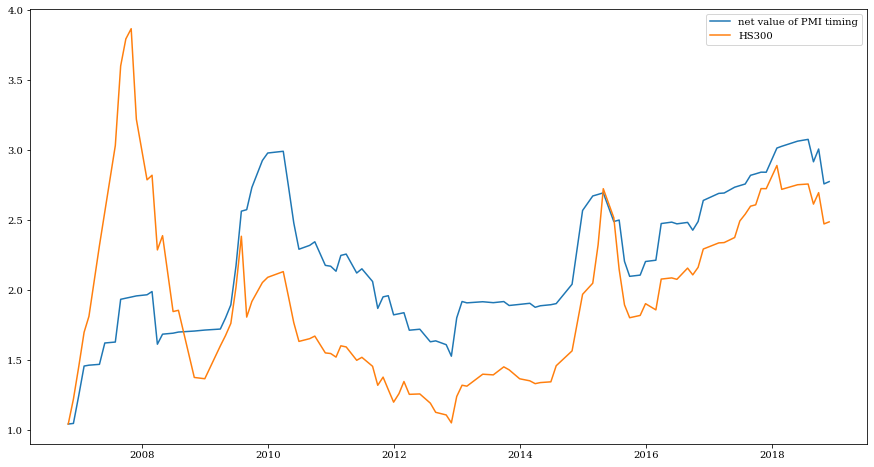

In [120]:
rf = 0.05/12
df_interest = pd.read_excel('SHIBOR数据.xls')
df_interest = df_interest.set_index('日期')
data_1 = [df_interest.iloc[max(0,i-10):i,1].mean() for i in range(len(df_interest))]
data_2 = [df_interest.iloc[max(0,i-10):i,1].std() for i in range(len(df_interest))]
df_interest['upper']= (np.array(data_1) + np.array(data_2))
df_interest['down']= (np.array(data_1) - np.array(data_2))
df_interest['position'] = 0
for i in range(1,len(df_interest)):
    if df_interest.iloc[i,1] > df_interest.iloc[i,4]:
        df_interest['position'][i] = 1
    elif df_interest.iloc[i,1] < df_interest.iloc[i,5]:
        df_interest['position'][i] = 0
    else:
        df_interest['position'][i] = df_interest['position'][i-1]

stock_price = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = stock_price.resample('M',how='last')
prices_growth = prices_M.pct_change()
df_pct = pd.concat([prices_growth,df_interest],axis=1)['2006-01-01':'2018-11-30'].dropna()
df_pct['growth'] = df_pct['position']*df_pct['close']+(1-df_pct['position'])*rf

plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot((df_pct['growth']+1).cumprod(),label='net value of PMI timing')
ax.plot((df_pct['close']+1).cumprod(),label='HS300')
ax.legend()
